In [10]:
!pip install -q bitsandbytes accelerate loralib
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.6/297.6 kB 32.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [1]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 13.3 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [2]:
import torch
import json
import numpy as np
from random import randint

import pandas as pd
import matplotlib.pyplot as plt

from transformers import OPTForCausalLM, AutoTokenizer
from datasets import load_dataset, Dataset
from sklearn.metrics import accuracy_score
from torch.optim.lr_scheduler import LambdaLR



from data_utils import (
    load_glue_datasets,
    load_hans_dataset,
    load_paws_qqp_dataset,
)
from context_utils import create_few_shot_context, select_demonstrations

In [3]:
# Check if CUDA is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Tokenizer + Models

In [23]:
tokenizer = AutoTokenizer.from_pretrained("facebook/opt-125m") # tokenizer
teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # teacher model
student_model = OPTForCausalLM.from_pretrained("facebook/opt-125m") # student model


# tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m") # tokenizer
# teacher_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # teacher model
# student_model = OPTForCausalLM.from_pretrained("facebook/opt-350m") # student model

In [24]:
for param in student_model.parameters():
    param.requires_grad = False

In [6]:
student_model

OPTForCausalLM(
  (model): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 768, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 768)
      (final_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-11): 12 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (final_layer_norm): LayerNorm((768,), ep

In [25]:
for param in student_model.parameters():
  param.requires_grad = False
  if param.ndim == 1:
    param.data = param.data.to(torch.float32)

student_model.gradient_checkpointing_enable()
student_model.enable_input_require_grads()

class CastOutputToFloat(torch.nn.Sequential):
  def forward(self, x): return super().forward(x).to(torch.float32)
student_model.lm_head = CastOutputToFloat(student_model.lm_head)

In [26]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [27]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=32,
    # target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

student_model = get_peft_model(student_model, config)
print_trainable_parameters(student_model)

trainable params: 589824 || all params: 125829120 || trainable%: 0.46875


## Datasets

In [12]:
data_set_used='mnli'
datasets, labels, num_labels = load_glue_datasets(data_set_used)

if data_set_used in ['mnli', 'rte', 'hans']:
    teacher_prompt = 'Think logically. Are the following sentences examples of entailment, yes or no?'
    student_prompt = 'Are the following sentences examples of entailment, yes or no?'
elif data_set_used in ['qqp', 'paws-qqp']:
    teacher_prompt = 'Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?'
    student_prompt = 'Are the following sentences duplicates or paraphrases of each other, yes or no?'

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261802 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6692 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9796 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [13]:
def create_train_batch_token(
    dataset_name,
    datasets,
    tokenizer,
    num_shots=16,
    device = 'cpu',
    num_sets=15,
    teacher_descr=teacher_prompt,
    student_descr=student_prompt
):
    datasets = datasets['train']

    batch_tokens = []
    batch_strings = []

    all_indices = []
    seed_nums = [randint(0, 1000) for i in range(num_sets)]
    for sn in seed_nums:
        # Randomly select demonstrations
        demonstrations, indices = select_demonstrations(
            datasets,
            balanced=True,
            rand_subset=True,
            num_shots=num_shots,
            seed=sn,
        )
        context, student_context = create_few_shot_context(
            dataset_name,
            demonstrations,
            datasets.features['label'],
            teacher_description=teacher_descr,
            student_description=student_descr,
        )
        token_data= {
            'context':(tokenizer(context, return_tensors="pt")).to(device),
            'query':(tokenizer(student_context, return_tensors="pt")).to(device)
        }
        string_data = {
            'context':context,
            'query':student_context
        }
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
        all_indices.extend(indices)

        # Select demonstrations by index and shuffle them
        shuffled_demo, _ = select_demonstrations(
            datasets,
            shuffle=True,
            from_idxlabels=indices,
        )
        shuffled_context, shuffled_student_context = create_few_shot_context(
            dataset_name,
            shuffled_demo,
            datasets.features['label'],
            teacher_description=teacher_descr,
            student_description=student_descr,
        )
        token_data= {
            'context':(tokenizer(shuffled_context, return_tensors="pt")).to(device),
            'query':(tokenizer(shuffled_student_context, return_tensors="pt")).to(device)
        }
        string_data = {
            'context':shuffled_context,
            'query':shuffled_student_context
        }
        batch_tokens.append(token_data)
        batch_strings.append(string_data)
        all_indices.extend(indices)

    return batch_tokens, batch_strings, all_indices

def create_validation_batch_token(
    dataset_name,
    datasets,
    tokenizer,
    device = 'cpu',
    prompt_descr=student_prompt,
    limit=10
):
    if dataset_name == 'mnli':
        split = 'validation_matched'
    else:
        split = 'validation'

    datasets = datasets[split]

    demonstrations, all_indices = select_demonstrations(datasets)
    batch_tokens = []
    batch_strings = []
    for dx in range(limit):
        context, _ = create_few_shot_context(
            dataset_name,
            [demonstrations[dx]],
            demonstrations.features['label'],
            teacher_description=prompt_descr,
            remove_label=True
        )
        token_data = (tokenizer(context, return_tensors="pt")).to(device)
        batch_tokens.append(token_data)
        batch_strings.append(context)

    labels = [datasets['label'][datasets['idx'].index(i)] for i in all_indices]
    labels = datasets.features['label'].int2str(labels)
    return batch_tokens, batch_strings, all_indices[:limit],labels[:limit]

In [14]:
train_data_tokens, train_data_strings, _ = create_train_batch_token(
    data_set_used, datasets, tokenizer=tokenizer, device=device
)

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

In [15]:
# Assuming `losses` is the list of epoch losses returned from the `train` function
def plot_losses(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses, marker='o', linestyle='-', color='b')
    plt.title('Training Loss Per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

Epoch 1, Total Loss: 6.18268071860075
Epoch 2, Total Loss: 5.248251091688871
Epoch 3, Total Loss: 3.187227312475443
Epoch 4, Total Loss: 1.3261298118159175
Epoch 5, Total Loss: 0.6641656085848808
Epoch 6, Total Loss: 0.4794257986359298
Epoch 7, Total Loss: 0.38173262448981404
Epoch 8, Total Loss: 0.247124875895679
Epoch 9, Total Loss: 0.21797053120099008
Epoch 10, Total Loss: 0.178539956221357
Total loss : 0.017853995622135698


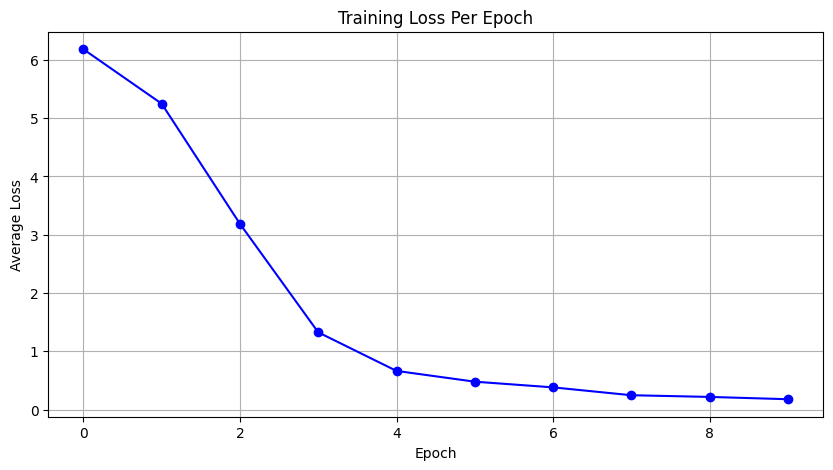

In [28]:
def train(data, epochs=10, batch_size=32, device='cpu'):
    student_model.to(device)
    teacher_model.to(device)

    student_model.train()
    optimizer = torch.optim.AdamW(student_model.parameters(), lr=1e-5, weight_decay=0.000001 )
    epoch_losses = []

    if (len(data) % batch_size != 0):
        num_batches = (len(data) // batch_size) + 1
    else:
        num_batches  = len(data) // batch_size

    num_datapoints = len(data)
    total_steps = num_batches * epochs
    warmup_ratio = int(0.1 * total_steps)

    def lr_schedular(current_step: int):
        if current_step < warmup_ratio:
            return float(current_step) / float(max(1,warmup_ratio))
        return 1.

    scheduler = LambdaLR(optimizer, lr_schedular)

    for epoch in range(epochs):
        total_loss = 0
        samples_left = num_datapoints

        for i in range(num_batches):
            batch_loss = 0
            if ((samples_left - batch_size) >= 0):
                samples_used = batch_size
                samples_left -= batch_size
            else:
                samples_used = samples_left
                samples_left = 0
            for j in range(samples_used):
                index = i * batch_size + j

                teacher_inputs = data[index]['context'].to(device)
                student_inputs = data[index]['query'].to(device)

                teacher_outputs = teacher_model.generate(
                    **teacher_inputs,
                    max_length=teacher_inputs['input_ids'].shape[-1] + 1,
                    output_scores=True,
                    return_dict_in_generate=True
                )
                teacher_probs = torch.nn.functional.softmax(teacher_outputs.scores[0], dim=-1)

                student_logits = student_model(**student_inputs).logits
                student_probs = torch.nn.functional.softmax(student_logits[:, -1, :], dim=-1)

                kl_divergence = torch.nn.functional.kl_div(student_probs.log(), teacher_probs, reduction='batchmean')

                optimizer.zero_grad()
                kl_divergence.backward()
                optimizer.step()

                batch_loss += kl_divergence.item()

            # Average loss for the batch
            batch_loss /= batch_size
            total_loss += batch_loss
            scheduler.step()
            # print(f"Epoch {epoch + 1}, Batch {i + 1}, Average Loss: {batch_loss}")


        # Average loss for the epoch
        epoch_loss = total_loss / num_batches
        epoch_losses.append(epoch_loss)

        print(f"Epoch {epoch + 1}, Total Loss: {epoch_loss}")

    print(f"Total loss : {total_loss/epochs}")
    plot_losses(epoch_losses)
    # torch.save(student_model, './models/student.pth')


train(train_data_tokens, epochs = 10, device=device)


In [20]:
def predict(model, source, target=None, device='cpu'):
    predict = []
    for token in source:
        output = model.generate(**token, max_length=token['input_ids'].shape[-1] + 1).to(device)
        decoded_output = tokenizer.decode(output[0], skip_special_tokens=True)
        predicted_label = decoded_output.split("Label:")[-1].strip().split('.')[0].strip()
        predict.append(predicted_label)

    return predict


student_prompt_tokens, student_prompt_strings, all_indices, all_labels = create_validation_batch_token(
    data_set_used, datasets, tokenizer=tokenizer, device=device, limit=1000
)
prediction = predict(student_model, student_prompt_tokens, device=device)



/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


In [21]:
accuracy_score(prediction,all_labels)

0.493

In [22]:
prediction

['yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'no',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 'yes',
 